## Illecillewaet inversion using a corrected inventory (outlines) of the glaciers of Illecillewaet Neve

In [74]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import salem
import oggm
import os
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import inversion
cfg.initialize(logging_level='WORKFLOW')
products_dir = '/home/pelto/Desktop/ice_thick/'

2019-09-25 10:50:53: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [ ]:
sh = gpd.read_file('/home/pelto/GIS/outlines/illec_divided_2016.shp') #nordic_divided_2014.shp') 

# OGGM set-up
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='illec_intersects', reset=True) #'nordic_intersects'
cfg.PARAMS['border'] = 10

divides = gpd.read_file('/home/pelto/GIS/outlines/illec_divided_2016.shp')

illec_new_shape_path = os.path.join(cfg.PATHS['working_dir'], 'illec_divided.shp')
divides.to_file(illec_new_shape_path) #template for Nordic, divides for Illec

from rgitools.funcs import compute_intersects
new_intersects = compute_intersects(divides)  #for_intersects  ##removed as no adjacent glacier at Nordic

#store our intersects to use them with OGGM afterwards
illec_intersects_path = os.path.join(cfg.PATHS['working_dir'], 'illec_divided_intersects.shp')
new_intersects.to_file(illec_intersects_path)

# This is important! We tell OGGM to recompute the glacier area for us
cfg.PARAMS['use_rgi_area'] = False
# This is the default anyway, but we set it here to be sure
cfg.PARAMS['use_intersects'] = True

# This is important!
cfg.set_intersects_db(illec_intersects_path)
illec_intersects_path

# This is important again - standard OGGM 
rgidf = gpd.read_file(illec_new_shape_path)
rgidf

gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)

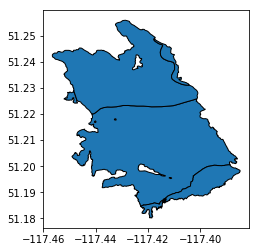

In [79]:
divides.plot(edgecolor='k');

Good! Let's use [rgitools](https://rgitools.readthedocs.io) to compute the intersects for this new situation: 

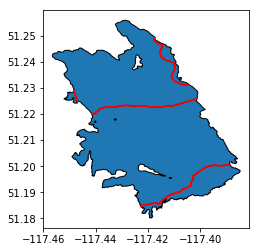

In [87]:
f, ax = plt.subplots()
divides.plot(ax=ax, edgecolor='k');  #for_intersects
new_intersects.plot(ax=ax, edgecolor='r');  

In [92]:
workflow.execute_entity_task(tasks.glacier_masks, gdirs);
workflow.execute_entity_task(tasks.compute_centerlines, gdirs);
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs);
workflow.execute_entity_task(tasks.catchment_area, gdirs);
workflow.execute_entity_task(tasks.catchment_width_geom, gdirs);
workflow.execute_entity_task(tasks.catchment_width_correction, gdirs);

2019-09-25 10:50:54: oggm.workflow: Execute entity task glacier_masks on 5 glaciers
2019-09-25 10:50:54: oggm.workflow: Execute entity task compute_centerlines on 5 glaciers
2019-09-25 10:50:54: oggm.workflow: Execute entity task initialize_flowlines on 5 glaciers
2019-09-25 10:50:54: oggm.workflow: Execute entity task catchment_area on 5 glaciers
2019-09-25 10:50:55: oggm.workflow: Execute entity task catchment_width_geom on 5 glaciers
2019-09-25 10:50:56: oggm.workflow: Execute entity task catchment_width_correction on 5 glaciers


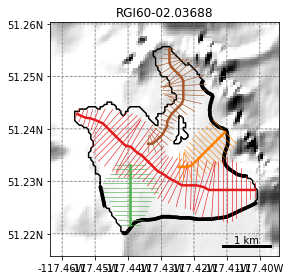

In [93]:
graphics.plot_catchment_width(gdirs[2], add_intersects=True, corrected=True);

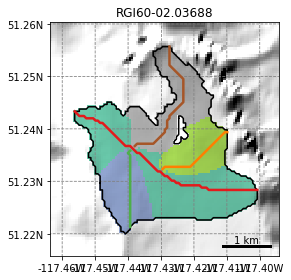

In [94]:
graphics.plot_catchment_areas(gdirs[2]);

In [95]:
##inversion time
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2019-09-25 10:50:56: oggm.workflow: Execute entity task glacier_masks on 5 glaciers
2019-09-25 10:50:57: oggm.workflow: Execute entity task compute_centerlines on 5 glaciers
2019-09-25 10:50:57: oggm.workflow: Execute entity task initialize_flowlines on 5 glaciers
2019-09-25 10:50:57: oggm.workflow: Execute entity task compute_downstream_line on 5 glaciers
2019-09-25 10:50:57: oggm.workflow: Execute entity task compute_downstream_bedshape on 5 glaciers
2019-09-25 10:50:57: oggm.workflow: Execute entity task catchment_area on 5 glaciers
2019-09-25 10:50:58: oggm.workflow: Execute entity task catchment_intersections on 5 glaciers
2019-09-25 10:50:58: oggm.workflow: Execute entity task catchment_width_geom on 5 glaciers
2019-09-25 10:50:58: oggm.workflow: Execute entity task catchment_width_correction on 5 glaciers
2019-09-25 10:50:58: oggm.workflow: Execute entity task process_cru_data on 5 glaciers
2019-09-25 10:50:59: oggm.workflow: Execute entity task local_t_star on 5 glaciers
2019-0

In [96]:
gdir = gdirs[2]
illec_new = gdir
tasks.init_present_time_glacier(gdir)

In [97]:
ds_divided = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_divided.close() 

In [98]:
print(ds_divided.distributed_thickness.mean())
thickness_divided = ds_divided.distributed_thickness

<xarray.DataArray 'distributed_thickness' ()>
array(108.96847, dtype=float32)


In [99]:
mfl=gdir.read_pickle('model_flowlines')
thickness_divided = mfl[-1].surface_h - mfl[-1].bed_h
thickness_divided.mean()

89.13867201099498

In [100]:
thickness_divided[thickness_divided>0].mean()

114.88984392528242

It works!

**The intersects in OGGM are used for two main things:**
- when a grid-point glacier section touches an intersect, it will be attributed a rectangular bed (instead of a parabolic one)
- when interpolating the ice thickness to a 2D grid, the boundary condition thickness=0 at the glacier outline is removed where there are intersects



## SMB gradient

In [101]:
num = 4 #num determines which gdir and gradient to use, refer to list below to select desired site

# min to max gradients
# grad = [5.8, 9.8, 5.9, 7.95, 6.2, 5.3, 5.8] #mm we m-1
#data points gradients
grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48]
# products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
# gdirs

# Print the standard MB gradient from OGGM default
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
# gdir = gdirs[num]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

In [102]:
# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 0.172215    intercept: 2575.022405   R-squared: 0.999189


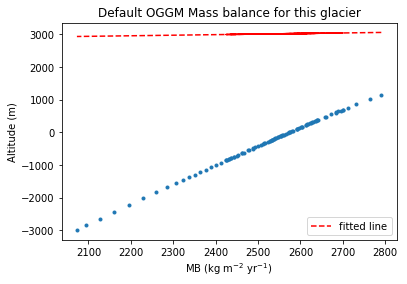

In [103]:
plt.plot(z, intercept + slope*z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

In [104]:
# See the result of the inversion
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

2019-09-25 10:51:01: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 5 glaciers


In [105]:
# ds_default.distributed_thickness.plot();
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
thickness_default.mean()

89.13867201099498

In [106]:
default_thick = thickness_default[thickness_default>0].mean()
print(np.round(default_thick,2))

114.89


In [107]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb

# gdir = gdirs[num]
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

2019-09-25 10:51:01: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers


In [108]:
params = gdir.read_pickle('linear_mb_params')
print(params)

{'ela_h': 2518.9657698709725, 'grad': 10.84}


In [109]:
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

slope default: 5.801980    intercept: -14940.503988   R-squared: 0.999189
slope: 10.840000    intercept: -27305.588945   R-squared: 1.000000


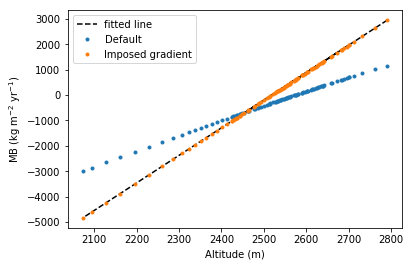

In [110]:
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(z, l_mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

plt.plot(z, intercept + slope*z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [111]:
# Now let's recompute the inversion based on this new gradient
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

2019-09-25 10:51:02: oggm.workflow: Execute entity task prepare_for_inversion on 5 glaciers
2019-09-25 10:51:02: oggm.workflow: Execute entity task mass_conservation_inversion on 5 glaciers
2019-09-25 10:51:02: oggm.workflow: Execute entity task filter_inversion_output on 5 glaciers
2019-09-25 10:51:02: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 5 glaciers


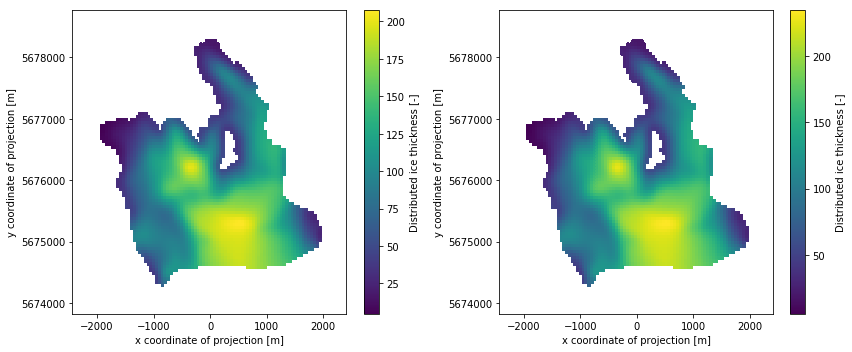

In [112]:
##side by side thickness...fine but hard to compare
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_default.distributed_thickness.plot(ax=ax1); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2);
plt.tight_layout();

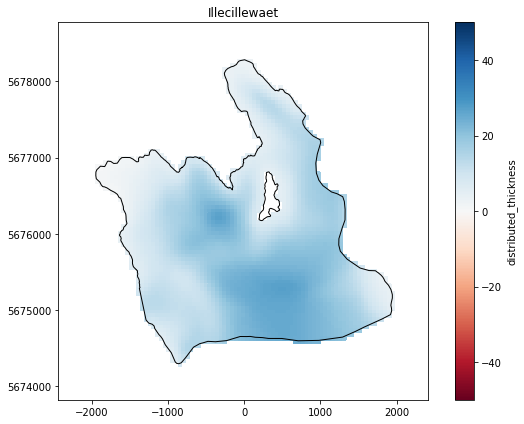

In [113]:
f, ax = plt.subplots(figsize=(8,6))
(ds_new - ds_default).distributed_thickness.plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
# plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

In [114]:
print(np.mean(ds_new.distributed_thickness))
print(ds_default.distributed_thickness.mean())

<xarray.DataArray 'distributed_thickness' ()>
array(123.52398, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(108.96847, dtype=float32)


In [115]:
mfl=gdir.read_pickle('model_flowlines')
thickness_MB = mfl[-1].surface_h - mfl[-1].bed_h
thickness_MB.mean()

100.89118791201257

In [116]:
MB_thick = thickness_MB[thickness_MB>0].mean()
print(np.round(MB_thick , 2))

130.04


In [117]:
diff =  MB_thick - default_thick
print(np.round(diff, 2))

15.15


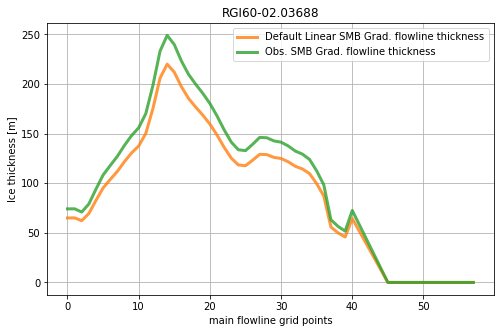

In [118]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(thickness_default, 'C1', label='Default Linear SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_MB, 'C2', label='Obs. SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
# fig.savefig(products_dir + glacier[num] +'.tiff')

In [121]:
utils.compile_glacier_statistics(gdirs, inversion_only=False)

2019-09-25 10:51:14: oggm.workflow: Execute entity task glacier_statistics on 5 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,...,flowline_mean_elev,flowline_max_elev,flowline_min_elev,flowline_avg_width,flowline_avg_slope,t_star,mu_star_glacierwide,mu_star_flowline_avg,mu_star_allsame,mb_bias
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-02.03684,02,02-03,,-117.449136,51.226430,0.085,Glacier,Land-terminating,Glacier or ice cap,0.003701,...,2559.176349,2577.881180,2514.235729,467.032967,0.181891,1936,180.674551,180.674551,True,321.668622
RGI60-02.03686,02,02-03,,-117.417996,51.207118,11.688,Glacier,Land-terminating,Glacier or ice cap,1.383570,...,2486.791693,2737.206595,1934.753203,1574.353448,0.151172,1937,157.197368,157.431573,False,321.134400
RGI60-02.03688,02,02-03,,-117.428689,51.234857,7.714,Glacier,Land-terminating,Glacier or ice cap,0.990581,...,2518.965770,2790.717416,2072.979342,1590.187590,0.138214,1937,166.086436,166.086436,True,321.225180
RGI60-02.03685,02,02-03,,-117.411198,51.239908,0.341,Glacier,Land-terminating,Glacier or ice cap,0.027023,...,2636.253320,2685.157917,2574.564559,357.442348,0.076300,1938,208.488147,208.488147,True,320.874434
RGI60-02.03690,02,02-03,,-117.399786,51.193068,1.414,Glacier,Land-terminating,Glacier or ice cap,0.145549,...,2538.461389,2737.608460,2289.435330,818.287037,0.131072,1937,171.913609,171.913609,True,320.810995


## Default Illecillewaet

In [46]:
WORKING_DIR = utils.gettempdir('illec_default')
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

2019-09-25 09:17:42: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [47]:
cfg.PARAMS['border'] = 10

In [48]:
rgidf = utils.get_rgi_glacier_entities(['RGI60-02.03688'])
gdirs = workflow.init_glacier_regions(rgidf)
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2019-09-25 09:17:44: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-09-25 09:17:44: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-09-25 09:17:44: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-09-25 09:17:44: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-09-25 09:17:44: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-09-25 09:17:44: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-09-25 09:17:44: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-09-25 09:17:44: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-09-25 09:17:45: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-09-25 09:17:4

In [49]:
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() 

In [50]:
print(ds_default.distributed_thickness.mean())
thickness_default = ds_default.distributed_thickness

<xarray.DataArray 'distributed_thickness' ()>
array(93.53087, dtype=float32)


In [51]:
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
thickness_default.mean()

78.49041368150627

In [52]:
thickness_default[thickness_default>0].mean()

101.57582947018459

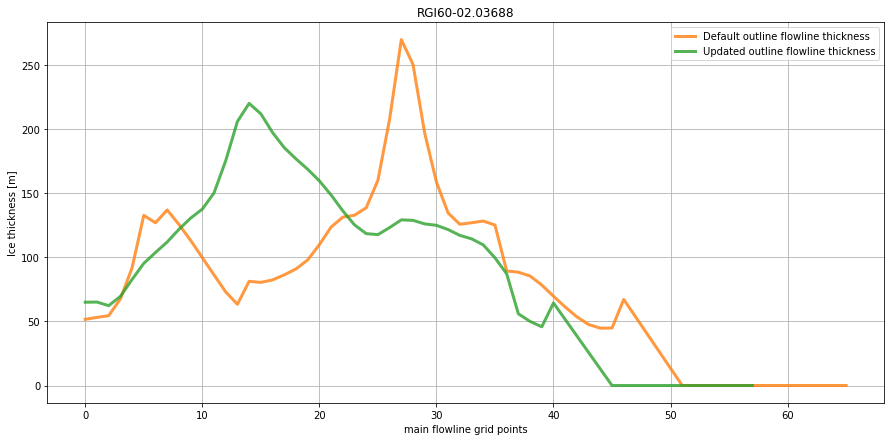

In [53]:
##hmmm off center
fig, ax = plt.subplots(figsize=[15,7])
ax.plot(thickness_default, 'C1', label='Default outline flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_divided, 'C2', label='Updated outline flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
fig.savefig(products_dir + '_illecillewaet_outline_flowline_thick.png', dpi=300)

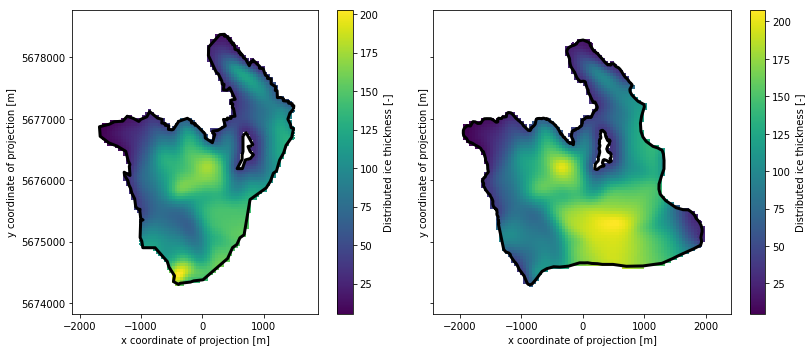

In [54]:
##side by side thickness...fine but hard to compare
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True);
ds_default.distributed_thickness.plot(ax=ax1); #default cmap is viridis
ds_divided.distributed_thickness.plot(ax=ax2);
gdir.read_shapefile('outlines').plot(ax=ax1, color='none', edgecolor='black', linewidth=3);
illec_new.read_shapefile('outlines').plot(ax=ax2, color='none', edgecolor='black', linewidth=3);
plt.tight_layout();
plt.savefig(products_dir + '_illecillewaet_side_by_side_outline_corr_thick.png', dpi=300)

In [55]:
# f, ax = plt.subplots(figsize=(8,6))
# (ds_divided - ds_default2).distributed_thickness.plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
# plt.ylabel('')
# plt.xlabel('')
# # plt.title(glacier[num])
# gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
# plt.tight_layout()
# # plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

## GPR Data import and comparison

In [56]:
shapefile = ['2017/Kokanee_17_final_WGS84.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84_clipped.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']

##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now

df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[num])

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

# Convert the longitudes and latitudes to the glacier map projection:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

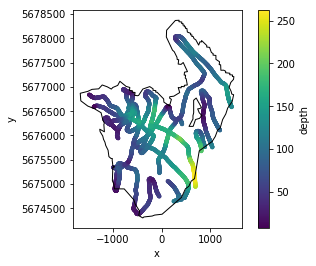

In [57]:
#plot these data
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth',cmap='viridis', s=10, ax=ax); #cmap='Blues',
geom.plot(ax=ax, facecolor='none', edgecolor='k');

In [58]:
#The measurement points of this dataset are very frequent and close to each other. There are plenty of them:
len(df)

6719

### Aggregated per grid point

In [59]:
df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [60]:
# Here, we will keep them all and interpolate the variables of interest at a the point's location. 
# We use xarray for this:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
#        'oggm_mb_above_z',
#        'oggm_mb_above_z_on_catch',
       ]

In [61]:
len(df_agg)

769

In [62]:
# Select
for vn in vns:
    df_agg[vn] = ds_divided[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))

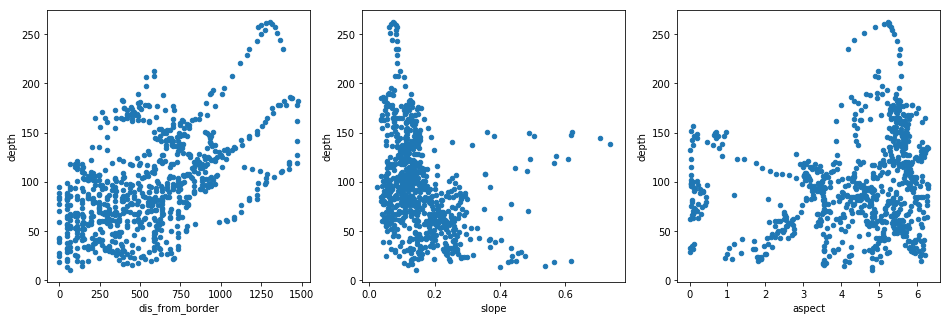

In [63]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

In [64]:
# Add the linear model data for comparison
# ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
df_agg['oggm_thick'] = ds_divided.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['obs_mb_grad_thick'] = ds_new.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))

In [65]:
print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('oggm_thick divided:', np.round(np.mean(df_agg['oggm_thick']) + srtm[num],2), np.round(np.std(df_agg['oggm_thick']) + srtm[num],2))
print('obs_mb_grad_thick:', np.round(np.mean(df_agg['obs_mb_grad_thick'])+ srtm[num],2), np.round(np.std(df_agg['obs_mb_grad_thick']) + srtm[num],2))

769 769
oggm_thick divided: 117.03 37.26
obs_mb_grad_thick: 133.42 42.95


In [66]:
print('GPR depth (m):', np.round(np.mean(df_agg['depth']),2), np.round(np.std(df_agg['depth']),2))

GPR depth (m): 97.21 48.35


In [67]:
df_diff = df_agg['depth'] - (df_agg['oggm_thick']) #- 1.0)
#df_diff
print('mean diff:', np.mean(df_diff))
print('med. diff:', np.nanmedian(df_diff))

mean diff: -22.402859396994785
med. diff: -22.45582336425781


In [68]:
srtm[num]

-5.86

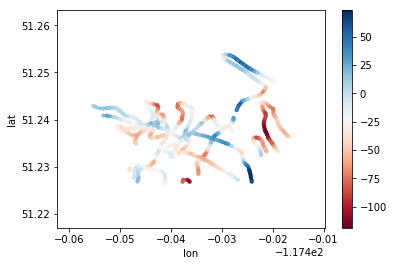

In [69]:
#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
diff = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=diff, cmap='RdBu', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='no

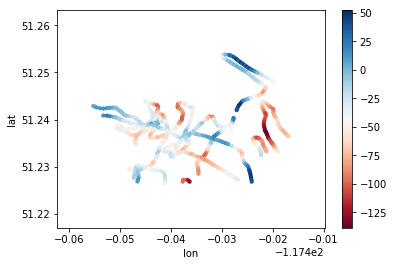

In [70]:
#GPR depth less OGGM SMB thickness
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
diff2 = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=diff2, cmap='RdBu', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='no

In [71]:
df_agg['obs_mb_grad_thick'].max()

235.14607